In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [5]:
class ConvNet(nn.Module):
    def __init__(self,in_ch=1,out_ch=10,image_size=32):
        super(ConvNet, self).__init__()
        self.net = \
            nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, stride = 1, padding=1),#( (32 + 2*1 - 3) / 1 + 1 = 32
            nn.BatchNorm2d(num_features= 16),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #(32/2 = 16)

            nn.Conv2d(16,32,kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #(16/2 = 8)

            nn.Conv2d(32,64,kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#(8/2 = 4)

            nn.Conv2d(64,128,kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#(4/2 = 2)

            nn.Flatten(),
            nn.Linear(int(128*2**2),100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100,out_ch),
            nn.Dropout(0.1)
        )
    
    def forward(self,x):
        x = self.net(x)
        y = F.softmax(x, dim=1)
        return y

In [6]:
# 平均と標準偏差を指定
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]
train = datasets.CIFAR10('data/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(mean, std),
                            #transforms.RandomRotation(10),
                            #transforms.RandomHorizontalFlip(),
                            
                              ]),
                              #target_transform=lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
                          )

test  = datasets.CIFAR10('data/', train=False, download=True, 
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(mean, std),
                              ]),
                          #target_transform=lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
                        )


Files already downloaded and verified
Files already downloaded and verified


In [7]:
device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
batch_size = 2048
train_data = DataLoader(dataset=train,shuffle=True,batch_size=batch_size)
test_data = DataLoader(dataset=test,shuffle=False,batch_size=batch_size)

in_ch = 3
out_ch = 10
image_size = 32

In [8]:
epoch = 60
lr = 0.05

In [9]:
conv_model = ConvNet(in_ch, out_ch, image_size=32).to(device)
conv_optim = optim.SGD(lr=lr, params=conv_model.parameters(),momentum=0.9,weight_decay=0.001)
#scheduler = optim.lr_scheduler.StepLR(conv_optim, step_size=20, gamma=0.05)
loss_fn = nn.CrossEntropyLoss()

epoch 59 accuracy : 0.7747641509433962


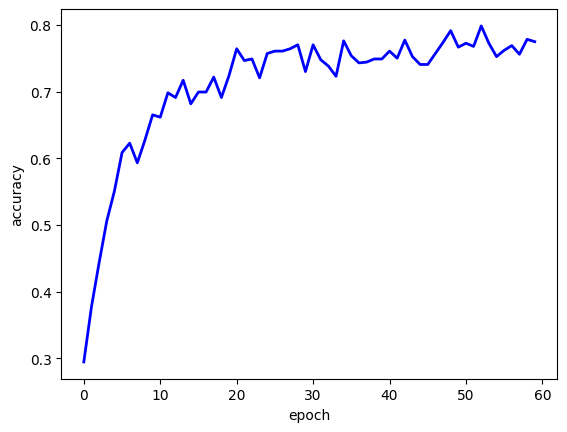

In [ ]:
loss = []
accuracy = []
conv_loss=0
for i in (range(epoch)):
    for batch, (X, y) in enumerate(train_data):
        X = X.to(device)
        y = y.to(device)
        conv_pred = conv_model(X)
        conv_loss = loss_fn(conv_pred, y)

        conv_optim.zero_grad()
        conv_loss.backward()
        conv_optim.step()
         # 精度の計算
        _, predicted = torch.max(conv_pred.data, 1)
        total = y.size(0)
        correct = (predicted == y).sum().item()
        batch_accuracy = correct / total
    accuracy.append(batch_accuracy)

    #scheduler.step() 
    print(f'epoch {i} accuracy : {batch_accuracy}')
    plt.plot(accuracy,linewidth=2,color='b')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()
    clear_output(wait=True)
    #print(f'epoch {i} loss : {conv_loss.item()}')

In [ ]:
conv_correct = 0
linear_correct = 0
total = 0
with torch.no_grad():
    for X, y in (test_data):
        X=X.to(device)
        y=y.to(device)
        conv_pred = conv_model(X)
        total += y.size(0)
        conv_correct += (conv_pred.argmax(1) == y).type(torch.float).sum().item()
print('Accuracy of the ConvNetwork on the test data: %d %%' % (100 * conv_correct / total))


Accuracy of the ConvNetwork on the test data: 71 %
